# Visualizing Data on Maps

Copyright © 2020 Unisse C. Chua

This notebook was prepared for the Data Visualization and Storytelling course under AIM's MS in Data Science program. 

---

In this notebook, we explore visualizing geospatial data specifically using [`geopandas`](https://geopandas.org/). 

`geopandas` is a library that taking the functionalities of [`pandas`](https://pandas.pydata.org/) and extending it with the geometric capabilities of [`shapely`](https://shapely.readthedocs.io/en/latest/manual.html), geometric plotting of [`descartes`](https://pypi.org/project/descartes/) + [`matplotlib`](https://matplotlib.org/) and geometric file access using [`fiona`](https://pypi.org/project/Fiona/).

It makes working with shapefiles easier and feel like we're using `pandas`.

**This notebook was created for an exploratory data analysis/visualization purposes ONLY.** It is in no way a complete analysis or a complete story yet. Using maps is only one method to present information but maps are the **easiest to misuse** for data storytelling. So we need to be careful.

---

To get started, let's load the packages we'll be using in this example.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Point
import geopandas as gpd

import os
from pathlib import Path

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('seaborn-deep')
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma']

## Base Maps
[Natural Earth](https://www.naturalearthdata.com/) provides high resolution raster and vector map data. In this example, we'll use the [1:50m resolution of the countries administrative boundaries shapefile](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/50m-admin-0-countries-2/).

They have a [higher resolution data](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) at 1:10m but to facilitate faster download times, we'll use the smaller file.

Alternatively, if you want country specific boundaries, there is a [**Database of Global Administrative Areas**](https://gadm.org/download_country_v3.html) (more commonly known as GADM). This is where you can download the shapefile of the Philippines' administrative boundaries.

### Downloading the data
Below are code snippets to include the file download in the notebook. This helps make the notebook more reproducible since the direct download URL is provided. The file paths are also checked before proceeding with reading the files. for analysis.

In [3]:
dataFolder = Path('data')
shpFile = Path('ne_50m_admin_0_countries.shp')
zipFile = Path('ne_50m_admin_0_countries.zip')

shpdir = dataFolder / shpFile

destination = dataFolder / zipFile

shpdir

PosixPath('data/ne_50m_admin_0_countries.shp')

In [4]:
if not os.path.isdir(dataFolder):
    print("Folder 'data' does not exist yet.")
    # Create folder
    os.mkdir(dataFolder)
    print("Folder 'data' created.")
    
if not os.path.isfile(shpdir):
    print("Shapefile does not exist! Proceed with download...")
    
    # download using cURL
    os.system("curl -O https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip")
    
    # move the zip to the data folder
    zipFile.replace(destination)
    
    if destination.exists():
        print("File moved insdide, unzipping")
        # unzip the file
        
        os.system("unzip " + str(destination) + " -d " + str(dataFolder) + '/')
        
        if shpdir.exists():
            print(str(shpdir), "exists! Continue")
else:
    print(str(shpdir), "exists! Continue")

data/ne_50m_admin_0_countries.shp exists! Continue


### Shapefiles
`geopandas` only works with **vector** geospatial data. To work with raster data, you would need `rasterio`.

The most common file type for vector data is in the form of **shapefiles**. Once you've downloaded the file, it will be in the form of a compressed **zip** file. Once you've extracted the contents, you should see multiple files with the **same filename** but **different extensions**. <span style="color: #a6001c;">It is important that these files stay in the same folder with the same filename.</span>

When we read in the file in `geopandas`, we only pass the `.shp` file but under the hood, it gets the detailed information about the geospatial data from the other files.

In [5]:
countries = gpd.read_file(shpdir)
countries.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,짐바브웨,Zimbabwe,Zimbabwe,Zimbábue,Зимбабве,Zimbabwe,Zimbabve,Zimbabwe,辛巴威,POLYGON ((31.28789062500002 -22.40205078125001...
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,잠비아,Zambia,Zambia,Zâmbia,Замбия,Zambia,Zambiya,Zambia,赞比亚,"POLYGON ((30.39609375000001 -15.64306640625, 3..."


### Countries Shapefile
Notice the `geometry` column. This is what makes the `DataFrame` a `GeoDataFrame`. Let's select only the columns we would need for merging later. Make sure not to drop the `geometry` column.

In [6]:
countries = countries[['ADMIN', 'SOVEREIGNT','NAME_EN', 'ADM0_A3','geometry']]

### Drawing the Map

To see what these geometries look like, we can simply call the `plot` function like a normal `DataFrame`. You can also pass the different arguments that `matplotlib` has for plotting a `DataFrame`.

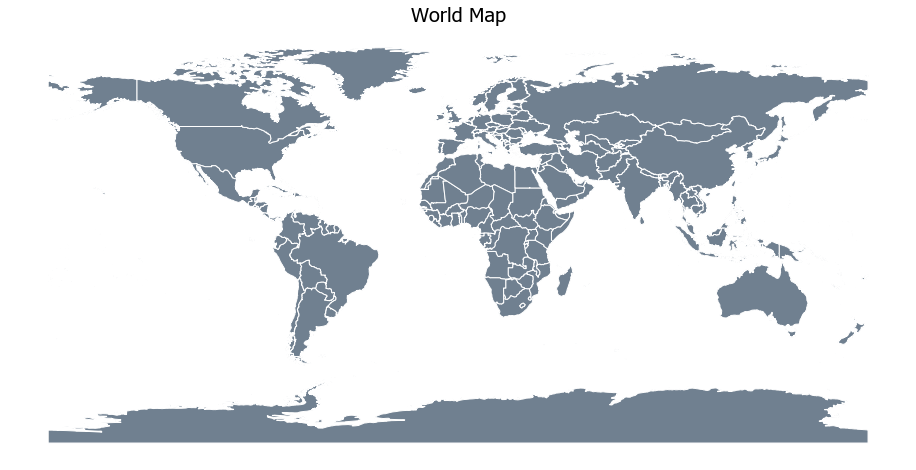

In [7]:
ax = countries.plot(figsize=(20,8), color='slategray', edgecolor='w', lw=1)
ax.axis(False)
ax.set_title('World Map');

#### Figure 1. World Map
This shows the different polygons of the countries, outlined with white. The color is the same for all since there's no numerical data to plot on the map. This is just a base map with the names of the countries.

## Layering Data on Maps

Since we now have a base map, let's add a new layer of data onto the map. For map visualizations, it's usually layers of data rather than just one data source. This is best seen in interactive maps (i.e. Google Maps). In Google Maps, we have the base polygons for the boundaries or land masses, then we have lines for the streets, more polygons for the buildings and some points for the points-of-interest locations for labels.

However, we can also achieve data layers in static visuals with `geopandas`.

---

### Global COVID-19 Confirmed Cases Dataset
Johns Hopkins University's Center for Systems Science and Engineering shared the data they collected on COVID-19 on [GitHub](https://github.com/CSSEGISandData). For this example, we'll use the confirmed cases from their [time series dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series).

In [8]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url)
confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562


This is what the data looks like. But we only need the latest data and the location information. Let's also rename the columns for easy access.

In [9]:
confirmed = confirmed[['Province/State', 'Country/Region', 'Lat', 'Long', '4/18/20']]
confirmed.columns = ['province', 'country', 'lat', 'lng', 'cases']

#### A bit of data cleaning...

The naming convention that JHU uses is not the standard names that matches the Natural Earth country names. Here's a quick snippet of which ones don't match.

In [10]:
confirmed[~confirmed.country.isin(countries.NAME_EN)]

,province,country,lat,lng,cases
18,NaN,Bahamas,25.034300,-77.396300,55
32,NaN,Cabo Verde,16.538800,-23.041800,58
49,Anhui,China,31.825700,117.226400,991
50,Beijing,China,40.182400,116.414200,593
51,Chongqing,China,30.057200,107.874000,579
52,Fujian,China,26.078900,117.987400,355
53,Gansu,China,37.809900,101.058300,139
54,Guangdong,China,23.341700,113.424400,1579
55,Guangxi,China,23.829800,108.788100,254
56,Guizhou,China,26.815400,106.874800,146


Ideally, you'd have to find and match them one by one (or using some algorithm to find the closest match), but just for example, let's just try some that we can find easily.

In [11]:
countries[countries.NAME_EN.str.contains('China')]

,ADMIN,SOVEREIGNT,NAME_EN,ADM0_A3,geometry
195,China,China,People's Republic of China,CHN,"(POLYGON ((118.1830078125 24.4962890625, 118.1..."


In [12]:
name_fixes = {
    'Korea, South': 'South Korea',
    'Taiwan*': 'Taiwan',
    'US': 'United States of America',
    'Bahamas': 'The Bahamas',
    'China': "People's Republic of China",
    'Timor-Leste': 'East Timor',
    'North Macedonia': 'Republic of Macedonia',
    'Gambia': 'The Gambia',
}

Using the dictionary mapping, we'll replace the names in the JHU data with the ones from the Natural Earth data.

In [13]:
confirmed['country'] = confirmed['country'].replace(name_fixes)

In [14]:
confirmed[~confirmed.country.isin(countries.NAME_EN)]

,province,country,lat,lng,cases
32,NaN,Cabo Verde,16.53880,-23.041800,58
83,NaN,Congo (Brazzaville),-4.03830,21.758700,143
84,NaN,Congo (Kinshasa),-4.03830,21.758700,307
86,NaN,Cote d'Ivoire,7.54000,-5.547100,801
88,NaN,Diamond Princess,0.00000,0.000000,712
91,NaN,Czechia,49.81750,15.473000,6606
103,NaN,Eswatini,-26.52250,31.465900,22
127,NaN,Holy See,41.90290,12.453400,8
241,NaN,West Bank and Gaza,31.95220,35.233200,418
248,NaN,Burma,21.91620,95.956000,98


We now have a shorter list. We can just drop these later when we merge.

---

Now, JHU also has a separated file for the United States. But it's pretty much the same. To get more lat/lng pairs, let's get the breakdown of the USA.

In [15]:
url_usa = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
confirmed_us = pd.read_csv(url_usa)
confirmed_us.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,130,133,133,133,133,135,135,136,136,136


Let's do the same thing for this set. Select only the fields we want and rename the columns to use the ones from above. We'll also rename "US" to "United States of America" using the same dictionary map.

In [16]:
confirmed_us = confirmed_us[['Province_State', 'Country_Region', 'Lat', 'Long_', '4/18/20']]
confirmed_us.columns = confirmed.columns
confirmed_us['country'] = confirmed_us['country'].replace(name_fixes)
confirmed_us.head()

,province,country,lat,lng,cases
0,American Samoa,United States of America,-14.2710,-170.1320,0
1,Guam,United States of America,13.4443,144.7937,136
2,Northern Mariana Islands,United States of America,15.0979,145.6739,14
3,Puerto Rico,United States of America,18.2208,-66.5901,1118
4,Virgin Islands,United States of America,18.3358,-64.8963,53


To check if the total is the same, here's the total count.

In [17]:
print("Confirmed Global - USA:", confirmed[confirmed['country'] == 'United States of America']['cases'].item())
print("Confirmed - USA:", confirmed_us['cases'].sum())

Confirmed Global - USA: 732197
Confirmed - USA: 732197


In [18]:
print(confirmed.shape)
print(confirmed_us.shape)

(264, 5)
(3261, 5)


We can now concatenate the two `DataFrames`. But we first remove the United States data from the global `DataFrame` and append the one from the US file.

In [19]:
covid_global = confirmed[confirmed['country'] != 'United States of America']
covid_global = pd.concat([covid_global, confirmed_us])
covid_global.head()

,province,country,lat,lng,cases
0,NaN,Afghanistan,33.0000,65.0000,933
1,NaN,Albania,41.1533,20.1683,548
2,NaN,Algeria,28.0339,1.6596,2534
3,NaN,Andorra,42.5063,1.5218,704
4,NaN,Angola,-11.2027,17.8739,24


Let's check for any `null` values for the **number of cases** and anything that's less than or equal to 0 can be dropped.

In [20]:
covid_global.isnull().sum()

province    181
country       0
lat           0
lng           0
cases         0
dtype: int64

In [21]:
covid_global[covid_global.cases <= 0].head()

,province,country,lat,lng,cases
231,Diamond Princess,Canada,0.000000,0.000000,-1
238,Recovered,Canada,0.000000,0.000000,0
0,American Samoa,United States of America,-14.271000,-170.132000,0
72,Alaska,United States of America,55.322224,-161.972202,0
73,Alaska,United States of America,52.725411,-110.408643,0


In [22]:
covid_global[covid_global.cases <= 0].shape

(525, 5)

According to this, there's 519 rows that have 0 cases and some noisy data. We can just drop all of these.

In [23]:
covid_global = covid_global[covid_global.cases > 0]
covid_global.shape

(2999, 5)

### Overlay Points
Since we have longitudes and latitudes, these are actually the x and y values of a map in a Cartesian plane. So we can easily plot the points like it was a scatter plot. 

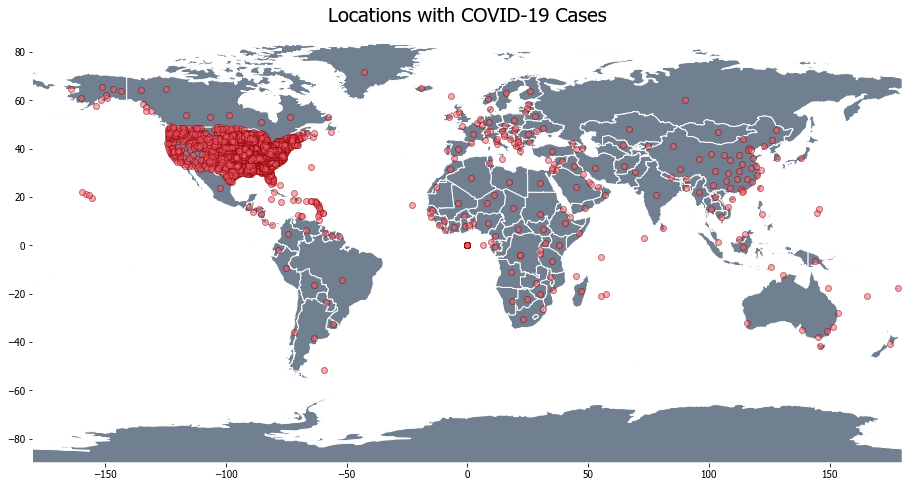

In [24]:
ax = countries.plot(figsize=(20,8), color='slategray', edgecolor='w', lw=1)
ax.set_title('Locations with COVID-19 Cases')
ax.scatter(covid_global.lng, covid_global.lat, color='#f25d6e', alpha=0.5, edgecolor='#8f0000')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90]);

#### Figure 2. Locations with COVID-19 Cases
This figure shows the locations with COVID-19 confirmed cases around the globe. Each dot represents either a country or a state/province within that country.

We can see that the United States has a lot of overlapping points because they have very state specific data. Although they have only 50+ states, the dataset shows over 2000 points. 

This figure doesn't show the counts yet. We're only showing that plotting a regular `pandas` `DataFrame` over a `GeoDataFrame` base map is possible. We visualized the base map first and reused the same `Axes` object to plot the scatter on top of the base map.

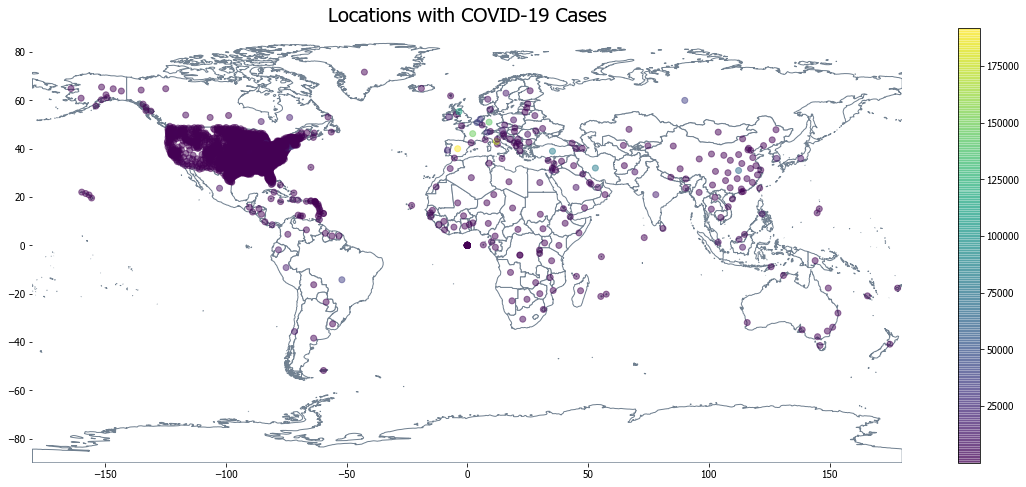

In [25]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

countries.plot(ax=ax, color='white', edgecolor='slategray', lw=1)

scatter = ax.scatter(covid_global.lng, covid_global.lat, c=covid_global['cases'], alpha=0.5, cmap=plt.cm.viridis)

ax.set_title('Locations with COVID-19 Cases')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])

# produce a legend with the unique colors from the scatter
fig.colorbar(scatter, ax=ax);

#### Figure 3. Locations with COVID-19 (colored according to the number of cases)
Same with a regular scatter plot, you can use a colormap to represent the sequential value of a column in the data.

This is the same plot as above except the points are now colored based on the absolute values of the number of cases. The colorbar on the side shows the representation of the numerical values.

### Creating a `GeoDataFrame`

Alternatively, you can also convert a regular `pandas` `DataFrame` with longitude and latitudes to a `GeoDataFrame`. You just have to turn the longitudes and latitudes to a **geometric point**, set the projection (crs = coordinate reference system), and create the `DataFrame`.

***Note:** The crs and epsg are concepts for geospatial analysis. For simiplicity sake, anything that has the regular longitude and latitudes with ranges -90 to 90 and -180 to 180, it follows the WGS:84 projection which is epsg:4326.*

In [26]:
# Create the geometry
geometry = [Point(xy) for xy in zip(covid_global['lng'], 
                                    covid_global['lat'])]

# Set the crs
crs = {'init': 'epsg:4326'}

# Create the GeoDataFrame from the DataFrame
confirmed_geodf = gpd.GeoDataFrame(covid_global, crs=crs, geometry=geometry)
confirmed_geodf.head()

,province,country,lat,lng,cases,geometry
0,NaN,Afghanistan,33.0000,65.0000,933,POINT (65 33)
1,NaN,Albania,41.1533,20.1683,548,POINT (20.1683 41.1533)
2,NaN,Algeria,28.0339,1.6596,2534,POINT (1.6596 28.0339)
3,NaN,Andorra,42.5063,1.5218,704,POINT (1.5218 42.5063)
4,NaN,Angola,-11.2027,17.8739,24,POINT (17.8739 -11.2027)


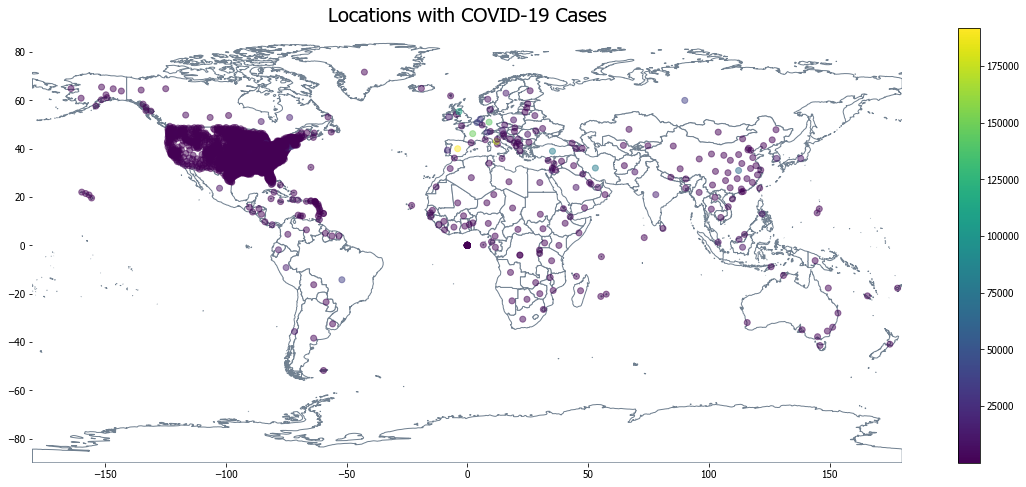

In [27]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

countries.plot(ax=ax, color='white', edgecolor='slategray', lw=1)
confirmed_geodf.plot(ax=ax, column='cases', cmap=plt.cm.viridis, alpha=0.5, legend=True)

ax.set_title('Locations with COVID-19 Cases')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90]);

#### Figure 4. Locations with COVID-19 (colored according to the number of cases)
This is now using 2 `GeoDataFrames` to plot the same data from the original `pandas` `DataFrame`. With the `GeoDataFrame`, we can easily set the color to the values using the `column` argument. We can also automatically create the colorbar by simply adding `legend=True`.

---

Looking at both Figures 3 and 4, the scale doesn't show the differences as much because of the major outliers. Let's create a logarithmic scale of the cases to better differentiate the differences between the number of cases in each location.

In [28]:
confirmed_geodf['log_cases'] = np.log10(confirmed_geodf['cases'])

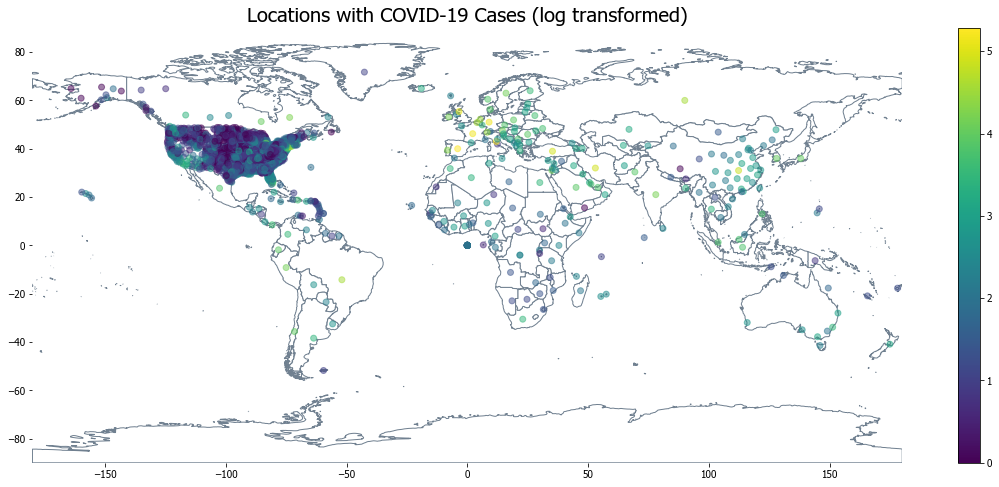

In [29]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

countries.plot(ax=ax, color='white', edgecolor='slategray', lw=1)
confirmed_geodf.plot(ax=ax, column='log_cases', cmap=plt.cm.viridis, alpha=0.5, legend=True)

ax.set_title('Locations with COVID-19 Cases (log transformed)')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90]);

#### Figure 5. Locations with COVID-19 cases (colored according to the log-scale of the cases)
The log-transformed number of cases gives us a better view of the differences between the different areas since the differences in absolute values are too far apart to differentiate. I used log base 10 to show that every step is an increase by $10^x$.

---

### Choropleth Maps

Now points on top of a base map is one thing, but normally, people enjoy seeing a "heat map" or a "colored map" for each territory instead of points on top of the territory. These are called **[choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map)**. We use colors to represent the values for the _entire area_.

To do this, we have to match the data we have with the country polygons. So let's aggregate the data to get the total counts per country instead of specific locations within the countries (for some).

We'll also recalculate the log-transformation of the new total counts per country.

In [30]:
cases_per_country = confirmed_geodf.groupby('country')['cases'].sum().reset_index()
cases_per_country['log_cases'] = np.log10(cases_per_country['cases'])
cases_per_country.head()

,country,cases,log_cases
0,Afghanistan,933,2.969882
1,Albania,548,2.738781
2,Algeria,2534,3.403807
3,Andorra,704,2.847573
4,Angola,24,1.380211


#### COVID-19 Cases per Country

Now our regular `pandas` `DataFrame` is just the country name with the cases and the log-transformed cases. We need the polygons to be able to create the choropleth map so we need to merge the `GeoDataFrame` with the regular `DataFrame`. <span style="color: #a6001c;">The order of the DataFrames is cruicial!</span> The `GeoDataFrame` goes on the left and the regular `DataFrame` goes on the right so that we end up with a `GeoDataFrame` and not a regular `DataFrame`.

But note here first that the number of rows do not completely match. There are countries in our shapefile that have no data on COVID.

By default, the merge done is an inner join. So it will drop on both if there's no match. For simplicity of the example, we won't check if there's a potential match. We tried to minimize the data loss earlier, but you should check further if you can to match what you can.

In [31]:
print("Natural Earth countries: ", countries.shape)
print("Countries with COVID-19: ", cases_per_country.shape)

Natural Earth countries:  (241, 5)
Countries with COVID-19:  (185, 3)


In [32]:
inner_merge = countries.merge(cases_per_country, left_on='NAME_EN', right_on='country')
inner_merge.head(3)

,ADMIN,SOVEREIGNT,NAME_EN,ADM0_A3,geometry,country,cases,log_cases
0,Zimbabwe,Zimbabwe,Zimbabwe,ZWE,POLYGON ((31.28789062500002 -22.40205078125001...,Zimbabwe,25,1.397940
1,Zambia,Zambia,Zambia,ZMB,"POLYGON ((30.39609375000001 -15.64306640625, 3...",Zambia,57,1.755875
2,Yemen,Yemen,Yemen,YEM,"(POLYGON ((53.08564453125001 16.648388671875, ...",Yemen,1,0.000000


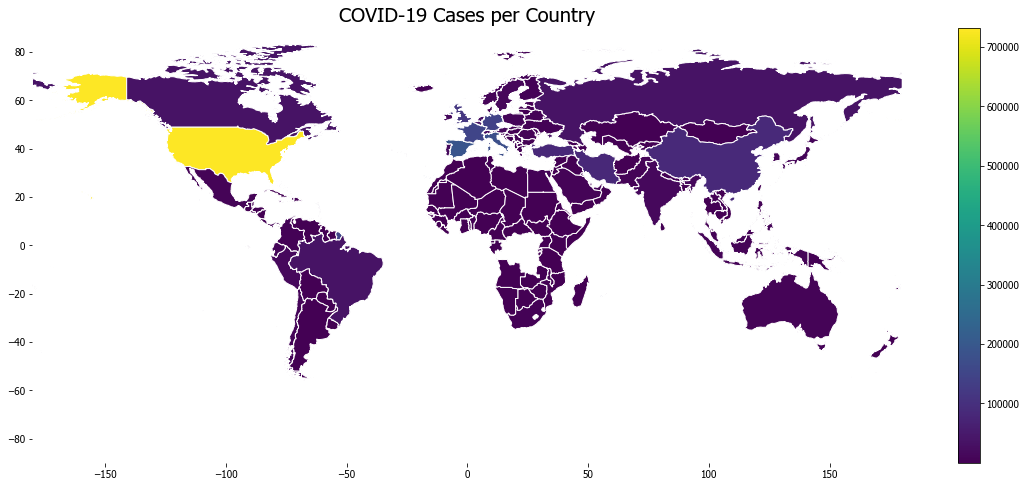

In [33]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

inner_merge.plot(ax=ax, column='cases', cmap=plt.cm.viridis, legend=True, edgecolor='w')

ax.set_title('COVID-19 Cases per Country')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90]);

#### Figure 6. COVID-19 Cases per Country (absolute counts)
This is now a choropleth map with each country's area colored according to the total number of cases reported on April 18, 2020. We can see that the United States has the highest number of cases but since this is in absolute values, we can't see the differences between countries.

This shows one of the challengese when making choropleth maps. We need to be careful with the values that we place and how we explain the color representation.

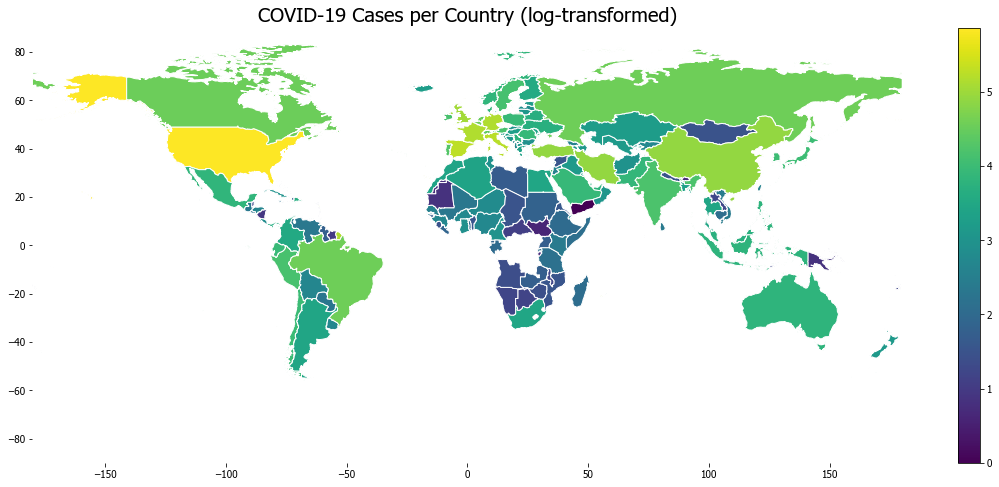

In [34]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

inner_merge.plot(ax=ax, column='log_cases', cmap=plt.cm.viridis, legend=True, edgecolor='w')

ax.set_title('COVID-19 Cases per Country (log-transformed)')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90]);

#### Figure 7. COVID-19 Cases per Country (log-transformed)
Alternatively, this is the choropleth map of the log-transformed number of confirmed COVID-19 cases across the world. We can now better see the differences between the countries in terms of their confirmed cases. But remember, when interpretting plots like these, it's best to look at the legend (to see the scale) and make sure that the plot is **labeled** properly.

---

Notice the missing countries? There's a huge white spot in between the colored parts. Let's make them visible.

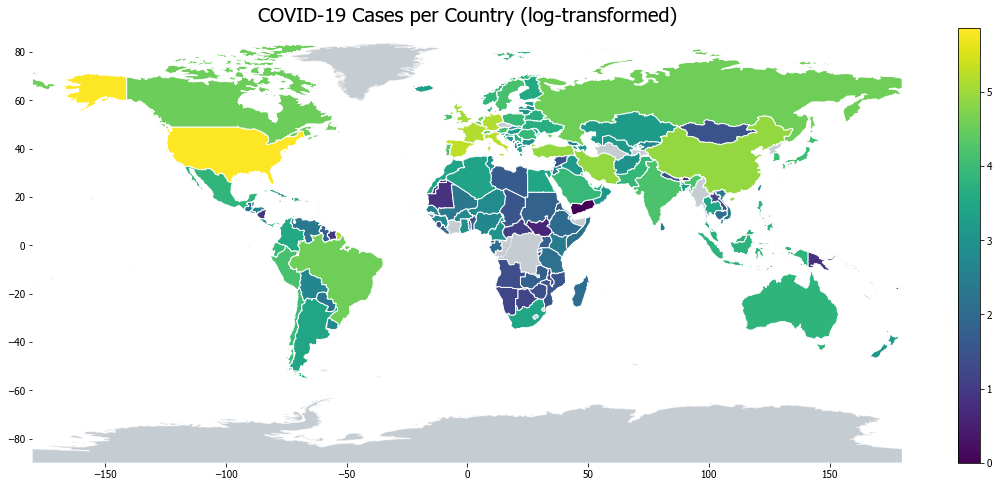

In [35]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

countries.plot(ax=ax, color='slategray', alpha=0.4, edgecolor='w')
inner_merge.plot(ax=ax, column='log_cases', cmap=plt.cm.viridis, legend=True, edgecolor='w')

ax.set_title('COVID-19 Cases per Country (log-transformed)')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90]);

#### Figure 8. COVID-19 Cases per Country (log-transformed)

The complete world map with the choropleth overlayed on top. This is basically the same as Figure 7 but the rest of the countries that have no reported confirmed cases from JHU's dataset is also present in the map. The color used is different (neutral) tos how that there is a country there but there's no cases.

Ideally, this is a more "complete" visual of the world since you show all of the countries (instead of white gaps). It tells a more "complete" story as well since you have countries that, either:
1. has no confirmed cases of COVID-19 at all
2. does not report any cases of COVID-19

### Spatial Join

The way we merged the data earlier was using the country name attribute. That was an **attribute join**.

`geopandas` provides the capability to do geometric operations. Since we have 2 `GeoDataFrames`, one with `Point`s and the other with `Polygon`s, we can try to find the following:
1. Which points are **within** the polygons? (`op='within'`)
2. Which points **intersect** with the polygons? (`op='intersects'`)
3. Which polygons **contain** points?(`op='contains'`)

For `within` and `contains`, the order of the `GeoDataFrame` arguments matter. `intersects` is the "catch-all" operation but depending on what **geometry** you want to keep, then the order also matters. A spatial join in `geopandas` always keeps the geometry of the **left** `GeoDataFrame`.

---

If we want to get _roughly_ the same figure as Figure 8, but _without_ having to replace the names manually, we can do a spatial join to get the country names from the `countries` `GeoDataFrame` and associate it with the `confirmed_geodf` `Point`s.

In [36]:
print("Number of rows in confirmed cases: ", len(confirmed_geodf))

print("Point intersects with Polygon: ", len(gpd.sjoin(confirmed_geodf, countries, op='intersects')))
print("Polygon intersects with Point: ", len(gpd.sjoin(countries, confirmed_geodf, op='intersects')))
print("Point within Polygon: ", len(gpd.sjoin(confirmed_geodf, countries, op='within')))
print("Polygon within Point: ", len(gpd.sjoin(countries, confirmed_geodf, op='within')))
print("Point contains Polygon: ", len(gpd.sjoin(confirmed_geodf, countries, op='contains')))
print("Polygon contains Point: ", len(gpd.sjoin(countries, confirmed_geodf, op='contains')))

Number of rows in confirmed cases:  2999
Point intersects with Polygon:  2939
Polygon intersects with Point:  2939
Point within Polygon:  2939
Polygon within Point:  0
Point contains Polygon:  0
Polygon contains Point:  2939


#### Spatial Join Operation comparison

Looking at the number of rows after the spatial join, we can see that we lost 60 rows. The rows that were dropped from the join means that those points did not intersect with any of the country polygons. These points might be over water or possibly **erroneous data**.

Let's do a `left` join to keep the points that have no corresponding country from the `countries` `GeoDataFrame`.

In [37]:
sjoined_gdf = gpd.sjoin(confirmed_geodf, countries, op='intersects', how='left')
print("Shape of the left sjoin dataframe: ", sjoined_gdf.shape)
sjoined_gdf.head()

Shape of the left sjoin dataframe:  (2999, 12)


,province,country,lat,lng,cases,geometry,log_cases,index_right,ADMIN,SOVEREIGNT,NAME_EN,ADM0_A3
0,NaN,Afghanistan,33.0000,65.0000,933,POINT (65 33),2.969882,237.0,Afghanistan,Afghanistan,Afghanistan,AFG
1,NaN,Albania,41.1533,20.1683,548,POINT (20.1683 41.1533),2.738781,236.0,Albania,Albania,Albania,ALB
2,NaN,Algeria,28.0339,1.6596,2534,POINT (1.6596 28.0339),3.403807,235.0,Algeria,Algeria,Algeria,DZA
3,NaN,Andorra,42.5063,1.5218,704,POINT (1.5218 42.5063),2.847573,234.0,Andorra,Andorra,Andorra,AND
4,NaN,Angola,-11.2027,17.8739,24,POINT (17.8739 -11.2027),1.380211,233.0,Angola,Angola,Angola,AGO


In [38]:
sjoined_gdf[sjoined_gdf.index_right.isnull()]

,province,country,lat,lng,cases,geometry,log_cases,index_right,ADMIN,SOVEREIGNT,NAME_EN,ADM0_A3
10,Northern Territory,Australia,-12.463400,130.845600,28,POINT (130.8456 -12.4634),1.447158,NaN,NaN,NaN,NaN,NaN
32,NaN,Cabo Verde,16.538800,-23.041800,58,POINT (-23.0418 16.5388),1.763428,NaN,NaN,NaN,NaN,NaN
37,Grand Princess,Canada,37.648900,-122.665500,13,POINT (-122.6655 37.6489),1.113943,NaN,NaN,NaN,NaN,NaN
61,Hong Kong,People's Republic of China,22.300000,114.200000,1024,POINT (114.2 22.3),3.010300,NaN,NaN,NaN,NaN,NaN
69,Macau,People's Republic of China,22.166700,113.550000,45,POINT (113.55 22.1667),1.653213,NaN,NaN,NaN,NaN,NaN
88,NaN,Diamond Princess,0.000000,0.000000,712,POINT (0 0),2.852480,NaN,NaN,NaN,NaN,NaN
92,Faroe Islands,Denmark,61.892600,-6.911800,184,POINT (-6.9118 61.8926),2.264818,NaN,NaN,NaN,NaN,NaN
101,NaN,Eritrea,15.179400,39.782300,39,POINT (39.7823 15.1794),1.591065,NaN,NaN,NaN,NaN,NaN
108,French Polynesia,France,-17.679700,149.406800,55,POINT (149.4068 -17.6797),1.740363,NaN,NaN,NaN,NaN,NaN
111,New Caledonia,France,-20.904300,165.618000,18,POINT (165.618 -20.9043),1.255273,NaN,NaN,NaN,NaN,NaN


#### Erronuous Longitude & Latitude pairs
Looking at the above table, we can see that we'll be losing **more** data when we do an `sjoin` because the longitude and latitudes of the locations are messy and _needs to be cleaned_. 

---

## Additional Analysis Needed

As stated in the introduction of this notebook, these are only exploratory visuals that give us a better idea of what the data looks like so far. When using maps for data storytelling, we need to be careful with **what** is shown and **how** it's shown. The narrative that goes with the map is also critical, along with the labels, legends and sources.

Not everyone is educated enough to understand how to read the different parts of a visualization so we need to be extra careful and detailed with what we place in our stories.

As a reference, I highly suggest reading [How Charts Lie: Getting Smarter about Visual Information](https://www.amazon.com/How-Charts-Lie-Getting-Information/dp/1324001569) by Alberto Cairo. He starts the book by giving a very _good_ example of how maps are **misused** for data storytelling. 

So for this COVID-19 mapping exercise, you might want to take a look at the population of the countries and how the number of cases are related to that. How dense is the population and how does that affect the number of cases too? Of course, the data also has a lot of limitations that should be highlighted and mentioned when presenting the full story.

Data, on its own, does not speak. We, as data story authors, have to be responsible in delivering the insights drawn from the data.